In this Notebook, each travelling salesmen has a different start location and has a cost.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import itertools


### Initialize the problem

In [2]:
numPoints = 20

# Generate random locations
X = []
Y = []

for i in range(numPoints):
    X.append(random.uniform(0,100))
    Y.append(random.uniform(0,100))
    

In [3]:
# Locations in a dataframe
df = pd.DataFrame()
df['ID'] = list(np.arange(1,numPoints+1))
df['X'] = X
df['Y'] = Y

# Put locations in a list
locations = list(df['ID'])


In [4]:
# Distance matrix
distance_matrix = []

for i in range(df.shape[0]):
    row = []
    
    for j in range(df.shape[0]):
        distance = np.sqrt((df['X'].iloc[i] - df['X'].iloc[j])**2 + (df['Y'].iloc[i] - df['Y'].iloc[j])**2)
        row.append(distance)
        
    distance_matrix.append(row)
    
# Make a copy of the distance matrix for manipulations
distance_matrix_copy = copy.deepcopy(distance_matrix)
distance_matrix_plot = copy.deepcopy(distance_matrix)
    

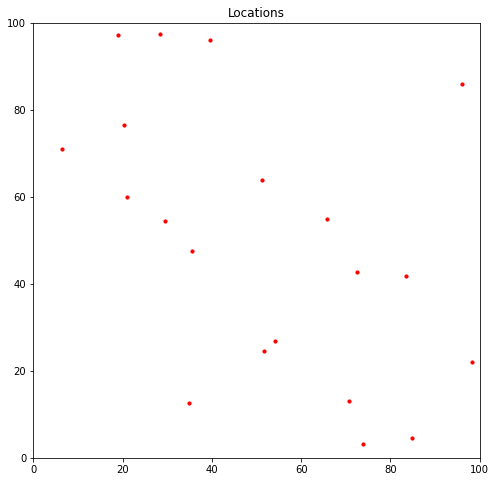

In [5]:
# Plot the locations
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='red', zorder=2000, s=10)
plt.title('Locations')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


In [6]:
# Color dictionary to plot the solution
color_dict = {0:'red', 1:'yellow', 2:'blue', 3:'green', 4:'purple'}


### Problem Setup

In [7]:
# number of salesmen
SALESMEN = 5

# cost per salesman
SALESMEN_COST = 500

locations_copy = copy.deepcopy(locations)

# routes for the salesmen
res = []

for i in range(SALESMEN):
    start_location = random.sample(locations_copy, k=1)[0]
    locations_copy.remove(start_location)
    res.append([start_location,start_location])


In [8]:
# Create random intial route
for i in range(len(locations_copy)):
    
    # Route to insert
    insertion = random.sample(list(range(1,SALESMEN+1)), k=1)[0]
    
    # Select a random location to insert
    random_location = random.sample(locations_copy, k=1)[0]
    locations_copy.remove(random_location)

    # Select a random spot to insert
    random_spot = random.sample(range(1,len(res[insertion-1])),k=1)[0]
    res[insertion-1].insert(random_spot,random_location)


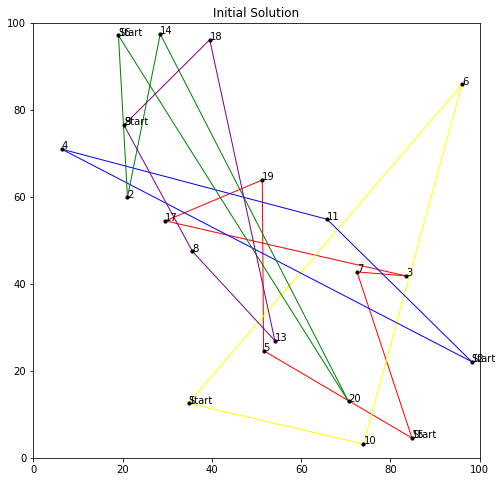

In [9]:
# Initial result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['ID'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))
    
for i in range(SALESMEN):
    plt.annotate(text = 'Start', xy = (df[df['ID'] == res[i][0]].iloc[0]['X'], df[df['ID'] == res[i][0]].iloc[0]['Y']))

for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k], linewidth=1)
            
plt.title('Initial Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


### Solving the problem

Find the shortest route by using as little number of salesmen.

In [10]:
locations_copy = copy.deepcopy(locations)

for i in range(SALESMEN):
    locations_copy.remove(res[i][0])


In [11]:
### Branch-and-cut Solution

# Develeopment of the solution
history = []

# shortest distance
shortest_route = [0]*SALESMEN

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        shortest_route[i] += SALESMEN_COST
        
# Objective
objective = sum(shortest_route)
history.append(objective)

print(res)
print('Lengths of the routes:', shortest_route)
print('Objective initial solution:', objective)


[[15, 7, 3, 17, 19, 5, 15], [1, 6, 10, 1], [12, 11, 4, 12], [16, 2, 14, 20, 16], [9, 8, 13, 18, 9]]
Lengths of the routes: [708.2007896486139, 721.4546507104891, 711.690377892158, 768.600960053438, 658.6449492379102]
Objective initial solution: 3568.5917275426095


In [16]:
# Initial solution
print(res)
print('Lengths of the routes:', shortest_route)
print('Current best solution:', objective)
print()

for tries in range(100000):

    # maximum number of locations to remove
    max_removes = int(np.round(len(locations)/2))

    # make a copy of the current route
    res_interim = copy.deepcopy(res)
    res_interim

    # locations to remove (at least 1)
    number = random.sample(range(1,max_removes), 1)[0]
    loc_remove = random.sample(locations_copy, number)
    loc_remove

    # remove locations from route
    for loc in (loc_remove):   
        for i in range(len(res_interim)):
            if loc in res_interim[i]:
                res_interim[i].remove(loc)

    # randomly insert locations into result
    for loc in (loc_remove):
        # Route to insert
        insertion = random.sample(range(1,SALESMEN+1), k=1)[0]

        insert_position = np.random.randint(1,len(res_interim[insertion-1]))
        res_interim[insertion-1].insert(insert_position, loc)

    current_route_interim = [0]*SALESMEN

    for i in range(len(res_interim)):
        for j in range(len(res_interim[i])-1):
            current_route_interim[i] += distance_matrix_copy[res_interim[i][j]-1][res_interim[i][j+1]-1]
        if len(res_interim[i]) > 2:
            current_route_interim[i] += SALESMEN_COST

    current_objective = sum(current_route_interim)

    if current_objective < objective:
        objective = current_objective
        res = res_interim

    history.append(objective)

print(res)

# Objective
shortest_route = [0]*SALESMEN

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        shortest_route[i] += SALESMEN_COST
        
print('Lengths of the routes:', shortest_route)
print('Objective:', objective)


[[15, 15], [1, 5, 13, 20, 10, 1], [12, 12], [16, 14, 18, 6, 3, 7, 11, 19, 8, 17, 2, 4, 16], [9, 9]]
Lengths of the routes: [0.0, 596.406720095046, 0.0, 755.2334342348425, 0.0]
Current best solution: 1351.6401543298884

[[15, 15], [1, 5, 13, 20, 10, 1], [12, 12], [16, 14, 18, 6, 3, 7, 11, 19, 8, 17, 2, 4, 16], [9, 9]]
Lengths of the routes: [0.0, 596.406720095046, 0.0, 755.2334342348425, 0.0]
Objective: 1351.6401543298884


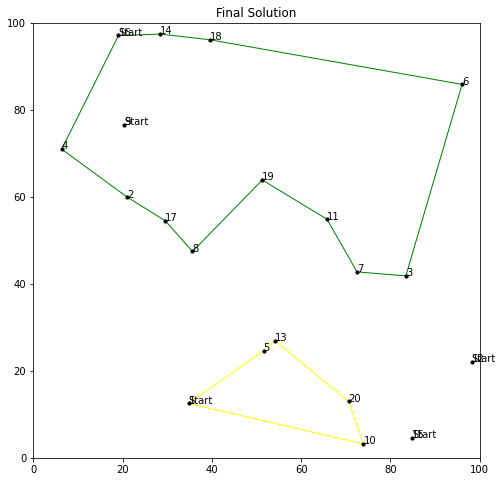

In [17]:
# Initial result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['ID'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))
        
for i in range(SALESMEN):
    plt.annotate(text = 'Start', xy = (df[df['ID'] == res[i][0]].iloc[0]['X'], df[df['ID'] == res[i][0]].iloc[0]['Y']))

for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k], linewidth=1)
            
plt.title('Final Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


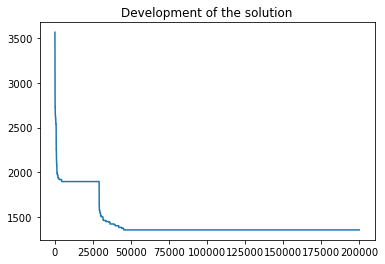

In [18]:
plt.plot(history)
plt.title('Development of the solution')
plt.show()
